tl;dr : *Inférence du transfert des voix entre candidats.*

Afin d'analyser les résultats des élections, par exemple les dernières élections présidentielles de 2022 en France, et de mieux comprendre la dynamique des choix de vote entre les différents groupes de population, il peut être utile d'utiliser des outils d'apprentissage automatique pour inférer des données *a priori* cachées dans les données. En particulier, inspiré par cet [article du Monde](https://www.lemonde.fr/les-decodeurs/article/2022/05/04/election-presidentielle-2022-quels-reports-de-voix-entre-les-deux-tours_6124672_4355770.html), on peut se poser la question de savoir si on peut extraire depuis les données brutes des élections une estimation des report de voix entre les choix de vote au premier tour et ceux qui sont effectués au deuxième tour.

Pour cela nous allons utiliser les outils mathématiques de l'apprentissage automatique et en particulier l'utilisation des probabilités. Cette théorie va nous permettre d'exprimer le fait que les résultats telles qu'ils sont obtenus peuvent présenter une variabilité mais que celle-ci réelle résulte de préférence de chaque individu dans la population votante. En particulier, on peut considérer que chaque individu va avoir une préférence pour chacun des candidats au premier et second tour et que les votes effectués vont correspondre à la réalisation de ces préférences (en effet, on ne peut voter que pour un candidat par scrutin). 

Bien sûr on a accès ni au vote de chaque individu et encore moins à ses préférences. Mais comme mais comme chaque bureau de vote présente des variabilité liée au contexte local et qui fait que la population a une préférence pour certains choix plutôt que d'autres, on peut considérer chaque bureau de vote comme une population individuelle pour lequel nous allons essayer de prédire les résultats du vote au deuxième tour. Cette prediction, si elle est efficace, peut donner une idée du transfert de vote entre les deux tours qui a lieu en fonction des préférences des votes de chaque individu.

<!-- TEASER_END -->

Celà se modélise mathématiquement par un [processus de Bernoulli](https://fr.wikipedia.org/wiki/Processus_de_Bernoulli) relatif à ces préférences.

Grâce à l'ouverture des données (notamment pour la recherche), on peut obtenir librement les résultats des [premier](https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/) et [second](https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-2nd-tour/) tours. Il est intéressant de noter que ses résultats sont indiqués pour chacun des bureaux de vote. 

Pour cela nous allons faire deux hypothèses: 

Tout d'abord nous allons estimer que pour chaque individu, il existe une préférence pour les candidats du premier tour ainsi que pour les candidats du deuxieme tour. Si on note les différentes alternatives au premier tour comme $i \in \{ \text{'nul'}, \text{'abstention'}, \ldots, \text{'Macron'}, \text{'Poutou'} \}$ et au deuxième tour  $j \in \{ \text{'nul'}, \text{'abstention'}, \ldots, \text{'Macron'}, \text{'Le Pen'} \}$. Alors, on peut écrire pour chaque individu $k$ les probabilités de vote $p^k_i$ et $q^k_j$ (chacune de ces valeurs étant comprises entre $0$ et $1$ représentant un biais de probabilité pour chacune des alternatives). On pourra vérifier que $\forall k$ (pour tout individu),  $\sum_i p^k_i = 1$ et $\sum_j q^k_j = 1$.

Avec une telle modélisation on peut prévoir les résultats du vote car les préférences de chacun individu pour telle ou telle choix doit se révéler au niveau de la population totale suivant le théorème central limite qui indique que la moyenne observée tend vers ces probabilités avec une précision (inverse de la variance) qui augmente linéairement avec le nombre d'observations. En particulier les résultats des votes au premier et second tour seront donnés par respectivement $\frac 1 K \cdot \sum_k p^k_i$ et $\frac 1 K \cdot \sum_k q^k_j$ avec $K$ la taille de la population (nous vérifierons ce point plus bas).

Une deuxième hypothèse que nous allons faire et que si on considère la transition entre les préférences qui sont faites au premier tour et celles qui sont faites au second tour, les préférences évoluent avec chaque invidu mais la transition est homogène au sein de la population (par exemple "une personne qui choisit de s'abstenir s'abstiendra"). C'est certe une hypothèse grossière mais assez générale pour refléter les tendances au niveau de la population globale. Cette hypothèse est basée sur la modélisation de séquence d'événements aléatoires basé sur un [processus dit de Markov](https://fr.wikipedia.org/wiki/Cha%C3%AEne_de_Markov). En particulier nous allons formaliser cette hypothèse en faisant l'hypothèse de l'existence d'une matrice de transition $M$ qui permet de prédire la préférence $\hat{q}^k_j$ d'un individu au second tour à partir de ses préférences au premier tour. En particulier, cette hypothèse peut être formulée comme un simple produit matriciel :

$$
\hat{q}^k_j = \sum_i M_{i, j} \cdot p^k_i 
$$

En termes plus simples, cette formule exprime que la préférence d'un individu au second tour et le mélange de ses préférences individuelles au premier tour avec des poids indiquant les affinités entre les différentes alternatives aux deux tours. Il est important de noter qu'il existe une contrainte  pour chaque colonne de cette matrice de transition de sorte que la somme des différentes éléments sur les différentes lignes de la matrice pour chaque colonne est égal à $1$ : $\forall j$, $ \sum_i M_{i, j} = 1$. Cette propriété découle des contraintes de représentation des préférences au premier et au deuxième tour que nous avons évoquées plus haut ($\sum_i p^k_i = 1$ et $\sum_j q^k_j = 1$).

D'une cette certaine façon, cette matrice de transition décrit exactement les affinités de chacun des individus pour les différents choix de vote au niveau de la population globale. C'est donc un indicateur des report de vote qui vont être effectivement effectués entre les deux tours.

## Collecte des données

La première partie de ce travail consiste à collecter les données et elle est représenté d'une façon utile. On va utiliser les données disponibles sur https://www.data.gouv.fr en se concentrant sur les résultats définitifs par bureau de vote. 
Commençons notre procédure avec le traitement des données du premier tour. Une fois que nous aurons décortiqué cette méthode, nous passerons au deuxième tour.

### Données du premier tour

Pour cela nous allons utiliser deux premières librairie python : `numpy` pour le traitement de données numériques puis `pandas` pour la représentation deces données sous forme de tableau tableaux.

In [1]:
import numpy as np
import pandas as pd

On peut directement enregistrer à partir de l'adresse des données puis extraire ses données numériques depuis le tableau Excel grâce a la [fonction suivante](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html):

In [2]:
import os

In [3]:
fname = '/tmp/T1.xlsx'

if not os.path.isfile(fname):
    url = 'https://static.data.gouv.fr/resources/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-1er-tour/20220414-152612/resultats-par-niveau-burvot-t1-france-entiere.xlsx' # XLSX
    import urllib.request
    urllib.request.urlretrieve(url, fname)


T1 = pd.read_excel(fname)

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

On peut avoir une première idée de ces données et du nombre total de bureaux de vote :

In [4]:
T1.tail()

<<<<<<< local


,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104
69677,ZZ,Français établis hors de France,6,6ème circonscription,229,Zurich,0001,24868,14101,56.70,...,47,0.19,0.44,12,M,DUPONT-AIGNAN,Nicolas,189,0.76,1.77
69678,ZZ,Français établis hors de France,11,11ème circonscription,231,Taipei,0001,1709,942,55.12,...,10,0.59,1.32,12,M,DUPONT-AIGNAN,Nicolas,10,0.59,1.32
69679,ZZ,Français établis hors de France,11,11ème circonscription,233,Nour-Soultan,0001,117,64,54.70,...,0,0.00,0.00,12,M,DUPONT-AIGNAN,Nicolas,1,0.85,1.96
69680,ZZ,Français établis hors de France,2,2ème circonscription,234,Monterrey,0001,713,553,77.56,...,1,0.14,0.63,12,M,DUPONT-AIGNAN,Nicolas,1,0.14,0.63
69681,ZZ,Français établis hors de France,2,2ème circonscription,235,Bahamas (Nassau),0001,136,78,57.35,...,0,0.00,0.00,12,M,DUPONT-AIGNAN,Nicolas,1,0.74,1.82


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T1' is not defined

>>>>>>> remote <modified: >


Les données sont organisées suivant des colonnes qui vont représenter les différents choix et aussi d'autres métadonnées. Il va falloir faire quelques hypothèses pour récupérer les données utiles…

In [5]:
T1.columns

<<<<<<< local


Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins',
       ...
       'Unnamed: 95', 'Unnamed: 96', 'Unnamed: 97', 'Unnamed: 98',
       'Unnamed: 99', 'Unnamed: 100', 'Unnamed: 101', 'Unnamed: 102',
       'Unnamed: 103', 'Unnamed: 104'],
      dtype='object', length=105)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T1' is not defined

>>>>>>> remote <modified: >


Première colonne concerne les nuls, blancs et abstention, que l'on peut enregistrer dans un nouveau tableau :

In [6]:
df_1 = T1[['Nuls', 'Blancs', 'Abstentions']].copy()
df_1.head()

<<<<<<< local


,Nuls,Blancs,Abstentions
0,1,16,108
1,1,3,38
2,5,18,266
3,6,15,265
4,8,10,246


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T1' is not defined

>>>>>>> remote <modified: >


In [7]:
df_1

<<<<<<< local


,Nuls,Blancs,Abstentions
0,1,16,108
1,1,3,38
2,5,18,266
3,6,15,265
4,8,10,246
...,...,...,...
69677,31,40,14101
69678,2,8,942
69679,0,2,64
69680,2,0,553


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


### extraction des résultats de vote

Les 23 premières colonnes correspondent aux métadonnées :

In [8]:
T1.columns[:23]

<<<<<<< local


Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau',
       'Sexe'],
      dtype='object')

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T1' is not defined

>>>>>>> remote <modified: >


Les colonnes suivant la colonne numéro 23 vont concerner les résultats candidats par candidats :

In [9]:
col_start = 23
col_par_cdt = 7

On peut extraire les noms des candidats présents au premier tour :

In [10]:
candidats = T1.iloc[0][col_start::col_par_cdt]
candidats

<<<<<<< local


Nom                   ARTHAUD
Unnamed: 30           ROUSSEL
Unnamed: 37            MACRON
Unnamed: 44          LASSALLE
Unnamed: 51            LE PEN
Unnamed: 58           ZEMMOUR
Unnamed: 65         MÉLENCHON
Unnamed: 72           HIDALGO
Unnamed: 79             JADOT
Unnamed: 86          PÉCRESSE
Unnamed: 93            POUTOU
Unnamed: 100    DUPONT-AIGNAN
Name: 0, dtype: object

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T1' is not defined

>>>>>>> remote <modified: >


On peut par exemple extraire les résultats pour le premier bureau de vote et donner le nombre de suffrages exprimés pour chaque candidat :

In [11]:
résultats = T1.iloc[0][(col_start+2)::col_par_cdt]
résultats

<<<<<<< local


Voix              3
Unnamed: 32       6
Unnamed: 39     150
Unnamed: 46      18
Unnamed: 53     149
Unnamed: 60      43
Unnamed: 67      66
Unnamed: 74       5
Unnamed: 81      30
Unnamed: 88      26
Unnamed: 95       3
Unnamed: 102     21
Name: 0, dtype: object

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T1' is not defined

>>>>>>> remote <modified: >


Grâce à ces connaissances, nous allons pouvoir maintenant récolter les données pour chaque candidat et pour tous les bureaux de vote en utilisant la fonction suivante :

In [12]:
for i_candidat, candidat in enumerate(candidats):
    i_col = col_start + i_candidat*col_par_cdt + 2
    print('# colonne', i_col, ' résultats=', T1.iloc[:, i_col].values)
    df_1[candidat] = T1.iloc[:, i_col].values

<<<<<<< local


# colonne 25  résultats= [3 2 4 ... 0 0 0]
# colonne 32  résultats= [ 6  7 30 ...  1  1  1]
# colonne 39  résultats= [150  50 159 ...  25  96  25]
# colonne 46  résultats= [18 10 24 ...  1  1  0]
# colonne 53  résultats= [149  23 237 ...   3   4   3]
# colonne 60  résultats= [43 14 69 ...  7 18 17]
# colonne 67  résultats= [ 66  41 216 ...   9  19   2]
# colonne 74  résultats= [ 5  3 15 ...  0  2  0]
# colonne 81  résultats= [30 10 25 ...  4 10  0]
# colonne 88  résultats= [26  8 40 ...  0  5  6]
# colonne 95  résultats= [3 3 8 ... 0 1 0]
# colonne 102  résultats= [21  0 13 ...  1  1  1]


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'candidats' is not defined

>>>>>>> remote <modified: >


Nous avons récolté les données utiles dans un nouveau tableau :

In [13]:
print(df_1.info())

<<<<<<< local


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69682 entries, 0 to 69681
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Nuls           69682 non-null  int64
 1   Blancs         69682 non-null  int64
 2   Abstentions    69682 non-null  int64
 3   ARTHAUD        69682 non-null  int64
 4   ROUSSEL        69682 non-null  int64
 5   MACRON         69682 non-null  int64
 6   LASSALLE       69682 non-null  int64
 7   LE PEN         69682 non-null  int64
 8   ZEMMOUR        69682 non-null  int64
 9   MÉLENCHON      69682 non-null  int64
 10  HIDALGO        69682 non-null  int64
 11  JADOT          69682 non-null  int64
 12  PÉCRESSE       69682 non-null  int64
 13  POUTOU         69682 non-null  int64
 14  DUPONT-AIGNAN  69682 non-null  int64
dtypes: int64(15)
memory usage: 8.0 MB
None


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


Ceci nous permet par exemple d'extraire les résultats pour un candidat donné et pour tous les bureaux de vote :

In [14]:
df_1['POUTOU']

<<<<<<< local


0         3
1         3
2         8
3         4
4         3
         ..
69677    47
69678    10
69679     0
69680     1
69681     0
Name: POUTOU, Length: 69682, dtype: int64

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


En particulier, on a le nombre suivant de bureaux de vote :

In [15]:
len(df_1)

<<<<<<< local


69682

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


Et on peut calculer pour chaque alternative le nombre total de choix ainsi que le nombre total de choix dans les data:

In [16]:
df_1.sum(), df_1.sum().sum()

<<<<<<< local


(Nuls               247151
 Blancs             543609
 Abstentions      12824169
 ARTHAUD            197094
 ROUSSEL            802422
 MACRON            9783058
 LASSALLE          1101387
 LE PEN            8133828
 ZEMMOUR           2485226
 MÉLENCHON         7712520
 HIDALGO            616478
 JADOT             1627853
 PÉCRESSE          1679001
 POUTOU             268904
 DUPONT-AIGNAN      725176
 dtype: int64,
 48747876)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


Par exemple, on note qu'environ 13 millions de personnes se sont abstenues, alors que environ 10 millions de personnes ont voté pour Macron.

Sous un format graphique on peut représenter ainsi les résultats du vote au premier tour et pour cela nous allons utiliser la librairie `matplotlib`:

In [17]:
import matplotlib.pyplot as plt

<<<<<<< local


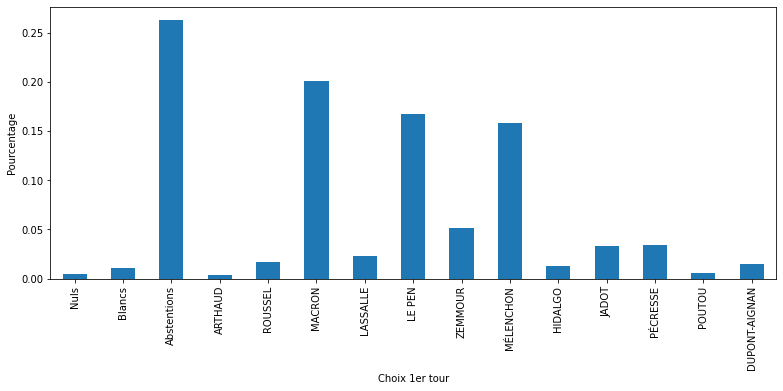

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


In [18]:
fig, ax = plt.subplots(figsize=(13, 5))
k = df_1.sum()/df_1.sum().sum()
ax = k.plot.bar(ax=ax)
ax.set_xlabel('Choix 1er tour')
ax.set_ylabel('Pourcentage');

On remarque le fort taux d'abstention qui a été observé au premier tour, ainsi que les deux candidats qui se distinguent par le plus grand nombre de voix et qui sont sélectionnés pour le second tour.

### données du 2ème tour

Nous allons maintenant répéter la même opération pour les données obtenues au deuxième tour :

In [19]:
fname = '/tmp/T2.xlsx'

if not os.path.isfile(fname):
    url = 'https://static.data.gouv.fr/resources/election-presidentielle-des-10-et-24-avril-2022-resultats-definitifs-du-2nd-tour/20220428-142301/resultats-par-niveau-burvot-t2-france-entiere.xlsx' # XLSX
    import urllib.request
    urllib.request.urlretrieve(url, fname)

T2 = pd.read_excel(fname)

T2.tail()

<<<<<<< local


,Code du département,Libellé du département,Code de la circonscription,Libellé de la circonscription,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,...,Voix,% Voix/Ins,% Voix/Exp,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
69677,ZZ,Français établis hors de France,6,6ème circonscription,229,Zurich,0001,24867,13153,52.89,...,10166,40.88,88.88,2,F,LE PEN,Marine,1272,5.12,11.12
69678,ZZ,Français établis hors de France,11,11ème circonscription,231,Taipei,0001,1703,928,54.49,...,611,35.88,82.23,2,F,LE PEN,Marine,132,7.75,17.77
69679,ZZ,Français établis hors de France,11,11ème circonscription,233,Nour-Soultan,0001,117,64,54.70,...,39,33.33,78.00,2,F,LE PEN,Marine,11,9.40,22.00
69680,ZZ,Français établis hors de France,2,2ème circonscription,234,Monterrey,0001,715,510,71.33,...,181,25.31,89.60,2,F,LE PEN,Marine,21,2.94,10.40
69681,ZZ,Français établis hors de France,2,2ème circonscription,235,Bahamas (Nassau),0001,137,78,56.93,...,35,25.55,68.63,2,F,LE PEN,Marine,16,11.68,31.37


ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

>>>>>>> remote


On vérifie que les données sont une nouvelle fois organisé suivant la même structure :

In [20]:
T2.columns

<<<<<<< local


Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau', 'Sexe',
       'Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34'],
      dtype='object')

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T2' is not defined

>>>>>>> remote <modified: >


In [21]:
T2.columns[:23]

<<<<<<< local


Index(['Code du département', 'Libellé du département',
       'Code de la circonscription', 'Libellé de la circonscription',
       'Code de la commune', 'Libellé de la commune', 'Code du b.vote',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau',
       'Sexe'],
      dtype='object')

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T2' is not defined

>>>>>>> remote <modified: >


In [22]:
T2.columns[23:]

<<<<<<< local


Index(['Nom', 'Prénom', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34'],
      dtype='object')

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T2' is not defined

>>>>>>> remote <modified: >


In [23]:
T2.iloc[0, 23:]

<<<<<<< local


Nom              MACRON
Prénom         Emmanuel
Voix                237
% Voix/Ins        36.86
% Voix/Exp        52.67
Unnamed: 28           2
Unnamed: 29           F
Unnamed: 30      LE PEN
Unnamed: 31      Marine
Unnamed: 32         213
Unnamed: 33       33.13
Unnamed: 34       47.33
Name: 0, dtype: object

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T2' is not defined

>>>>>>> remote <modified: >


In [24]:
col_start = 23
col_par_cdt = 7
candidats = T2.iloc[0][col_start::col_par_cdt]
candidats

<<<<<<< local


Nom            MACRON
Unnamed: 30    LE PEN
Name: 0, dtype: object

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T2' is not defined

>>>>>>> remote <modified: >


Une fois cette vérification faite nous pouvons extraire les données dans un nouveau tableau :

In [25]:
df_2 = T2[['Nuls', 'Blancs', 'Abstentions']].copy()
#df_1 = df_1.rename(columns={"Nuls": "1_Nuls", "Abstentions": "1_Abstentions"})
df_2.head()

<<<<<<< local


,Nuls,Blancs,Abstentions
0,5,42,146
1,3,23,45
2,22,71,322
3,18,45,313
4,21,87,303


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'T2' is not defined

>>>>>>> remote <modified: >


Nous vérifions aussi que nous avons le même nombre de bureaux de vote :

In [26]:
len(df_2)

<<<<<<< local


69682

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_2' is not defined

>>>>>>> remote <modified: >


In [27]:
for i_candidat, candidat in enumerate(candidats):
    i_col = col_start + i_candidat*col_par_cdt + 2
    print(i_col, T2.iloc[:, i_col].values)
    df_2[candidat] = T2.iloc[:, i_col].values

<<<<<<< local


25 [237  94 360 ...  39 181  35]
32 [213  48 355 ...  11  21  16]


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'candidats' is not defined

>>>>>>> remote <modified: >


In [28]:
df_2

<<<<<<< local


,Nuls,Blancs,Abstentions,MACRON,LE PEN
0,5,42,146,237,213
1,3,23,45,94,48
2,22,71,322,360,355
3,18,45,313,426,327
4,21,87,303,449,353
...,...,...,...,...,...
69677,49,227,13153,10166,1272
69678,6,26,928,611,132
69679,0,3,64,39,11
69680,1,2,510,181,21


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_2' is not defined

>>>>>>> remote <modified: >


De la même façon que pour le premier tour, nous pouvons représenter les résultats totaux obtenus au second tour de façon graphique :

<<<<<<< local


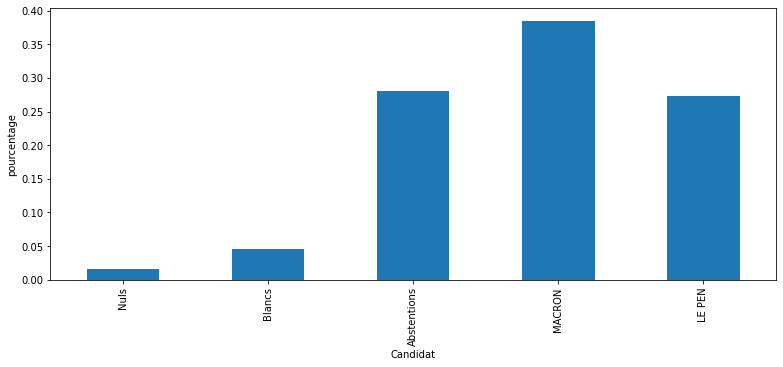

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_2' is not defined

>>>>>>> remote <modified: >


In [29]:
fig, ax = plt.subplots(figsize=(13, 5))
k = df_2.sum()/df_2.sum().sum()
ax = k.plot.bar(ax=ax)
ax.set_xlabel('Candidat')
#ax.set_xlim(1, 10)
#ax.set_xticks(np.arange(1, 10)+.5)
#ax.set_xticklabels(np.arange(1, 10)) , rotation=45
ax.set_ylabel('pourcentage');

### non aux nans

Certains bureaux de vote n'ont pas de votants au premier ou au deuxieme. Ceci peut engendrer des problèmes numériques en générant des divisions par zéro, des `Not a Number (NaN)` dans le jargon informatique. Comme ceux-ci représentent un nombre très faible d'électeurs nous allons les ignorer par rapport au reste de la population.

Nous pouvons d'abord compter le nombre de bureaux de vote qui n'ont aucun suffrage enregistré:

In [30]:
(df_1.sum(axis=1)==0).sum(), (df_2.sum(axis=1)==0).sum()

<<<<<<< local


(10, 11)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


Nous pouvons "effacer" ces bureaux du vote en commençant par filtrer ceux qui n'ont aucun suffrage enregistré au premier tour :

In [31]:
df_2.drop(df_2.loc[df_1.sum(axis=1)==0].index, inplace=True)
df_1.drop(df_1.loc[df_1.sum(axis=1)==0].index, inplace=True)

<<<<<<< local <removed>


NameError: name 'df_2' is not defined

>>>>>>> remote <modified: >


In [32]:
(df_1.sum(axis=1)==0).sum(), (df_2.sum(axis=1)==0).sum()

<<<<<<< local


(0, 2)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


Et maintenant répéter la même procédure sur les bureaux de vote qui n'ont aucun suffrage enregistré au second tour :

In [33]:
df_1.drop(df_1.loc[df_2.sum(axis=1)==0].index, inplace=True)
df_2.drop(df_2.loc[df_2.sum(axis=1)==0].index, inplace=True)

<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


In [34]:
(df_1.sum(axis=1)==0).sum(), (df_2.sum(axis=1)==0).sum()

<<<<<<< local


(0, 0)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


### statistiques de second ordre

Comme cela est montré dans l'[article du Monde](https://www.lemonde.fr/les-decodeurs/article/2022/05/04/election-presidentielle-2022-quels-reports-de-voix-entre-les-deux-tours_6124672_4355770.html) on peut montrer la dépendance entre les choix qui sont effectués au premier tour et ceux qui sont effectués au deuxième tour. On va utiliser des représentations graphiques similaires à ceux de l'article pour d'une première part les répliquer et vérifier que la méthode est correct et d'un autre côté pour mieux comprendre comment nous pouvons tirer dans ses enseignements depuis ces observations.

In [35]:
df_12 = pd.DataFrame()

In [36]:
df_12['1_MÉLENCHON'] = df_1['MÉLENCHON'].copy()
df_12['MACRON'] = df_2['MACRON'].copy()

<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


In [37]:
df_12.info()

<<<<<<< local


<class 'pandas.core.frame.DataFrame'>
Int64Index: 69670 entries, 0 to 69681
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   1_MÉLENCHON  69670 non-null  int64
 1   MACRON       69670 non-null  int64
dtypes: int64(2)
memory usage: 1.6 MB


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

>>>>>>> remote


In [38]:
df_12['1_MÉLENCHON'] = df_12['1_MÉLENCHON']/df_1.sum(axis=1)
df_12['MACRON'] = df_12['MACRON']/df_2.sum(axis=1)

KeyError: '1_MÉLENCHON'

In [39]:
import seaborn as sns

<<<<<<< local


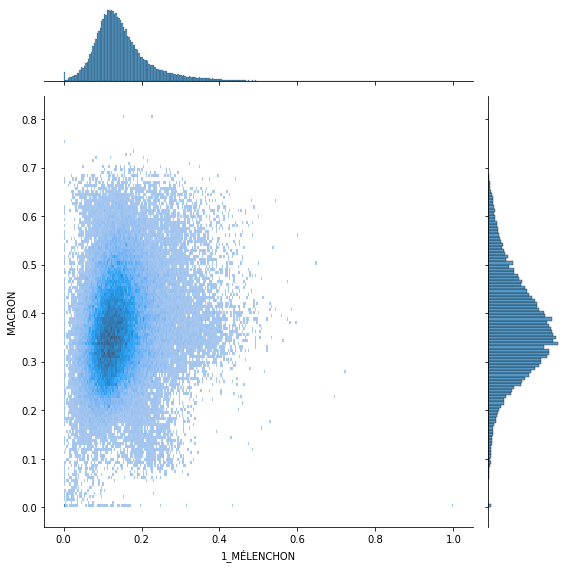

KeyError: '1_MÉLENCHON'

>>>>>>> remote


In [40]:
sns.jointplot(x=df_12['1_MÉLENCHON'], y=df_12['MACRON'], kind='hist', height=8);

On remarque effectivement une dépendance entre le choix. Un premier candidat effectué au premier tour et celui qui est effectué au second tour. Nous allons essayer d'inférer de façon plus précise cette dépendance grâce au modèle de transition que nous avons exposer au début de cet article.

## fit model de transfert des voix

Tenant que nous avons récolté toutes les données pour les deux tours, et que nous avons une idée qu'il existe une dépendance entre les choix qui sont faits entre un tour et le suivant, nous allons pouvoir utiliser des librairies de tes apprentissage automatique machine Learning en anglais pour pouvoir insérer le report de voix entre les deux tours :. Pour cela nous allons utiliser un travail précédemment effectué appliquer à l'[exploration du comportement humain](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html) ou alors pour [l'épidémiologie du Covid](https://laurentperrinet.github.io/sciblog/posts/2020-10-10-fitting-covid-data.html).

### Formatage des données au format de la librairie `torch`

Pendant un aperçu des résultats au premier tour :

In [41]:
df_1.head()

<<<<<<< local


,Nuls,Blancs,Abstentions,ARTHAUD,ROUSSEL,MACRON,LASSALLE,LE PEN,ZEMMOUR,MÉLENCHON,HIDALGO,JADOT,PÉCRESSE,POUTOU,DUPONT-AIGNAN
0,1,16,108,3,6,150,18,149,43,66,5,30,26,3,21
1,1,3,38,2,7,50,10,23,14,41,3,10,8,3,0
2,5,18,266,4,30,159,24,237,69,216,15,25,40,8,13
3,6,15,265,6,13,201,19,210,68,194,19,46,42,4,20
4,8,10,246,8,18,229,28,227,74,227,16,65,35,3,19


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


Nous avons donc comptabilisé ces différentes alternatives au premier tour :

In [42]:
len(df_1.columns)

<<<<<<< local


15

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


De sorte que sur les bureaux de vote que nous avons validé nous avons les deux tableaux suivants :

In [43]:
df_1.values.shape, df_2.values.shape

<<<<<<< local


((69670, 15), (69670, 5))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


Nous allons maintenant utiliser la librairie `torch` pour enregistrer ses données sous la forme d'une matrice (ou tenseur dans le jargon de cette librairie) :

In [44]:
import torch

X_1, X_2 = df_1.values, df_2.values
x_1, x_2 = torch.Tensor(X_1), torch.Tensor(X_2)


<<<<<<< local <removed>


ModuleNotFoundError: No module named 'torch'

>>>>>>> remote <modified: >


In [45]:
x_1.shape

<<<<<<< local


torch.Size([69670, 15])

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'x_1' is not defined

>>>>>>> remote <modified: >


Ainsi nous allons très facilement pouvoir représenter les données pour pouvoir les apprendre. Une pratique extrêmement importante dans l'apprentissage automatique et de séparer les données qui sont utilisés pour apprendre le modèle, avec celles qui sont utilisés pour tester ce modèle :

In [46]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(x_1, x_2)

# Random split
train_set_size = int(len(dataset) * 0.8)
test_set_size = len(dataset) - train_set_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, test_set_size])


<<<<<<< local <removed>


ModuleNotFoundError: No module named 'torch'

>>>>>>> remote <modified: >


Ainsi nous pourrons utiliser l'ensemble d'apprentissage au cours des différentes époques d'apprentissage utilisé plus bas :

In [47]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

<<<<<<< local <removed>


NameError: name 'DataLoader' is not defined

>>>>>>> remote <modified: >


In [48]:
for n_1, n_2 in train_loader:
    break

<<<<<<< local <removed>


NameError: name 'train_loader' is not defined

>>>>>>> remote <modified: >


En particulier nous allons couper les données de façon aléatoire puis il est représenté sous la forme de différents « paquet » dont la taille est fixé ici à 32, et nous verrons plus tard que si cette procédure permet d'accélérer l'apprentissage la taille du paquet n'a plus d'influence sur le résultat final.

In [49]:
n_1.shape, n_2.shape

<<<<<<< local


(torch.Size([32, 15]), torch.Size([32, 5]))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'n_1' is not defined

>>>>>>> remote <modified: >


Dans chaque paquet nous pouvons compter le nombre de votes pour les différentes alternatives :

In [50]:
sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
sum_1, sum_2

<<<<<<< local


(tensor([ 492.,  153.,  844.,  959., 1182.,  146.,  150.,  997., 1071., 1125.,
          283.,  291.,  367.,   96.,  862.,  120.,  687.,  270.,  647.,   49.,
         1687.,  762.,  806., 1184., 1260., 1197.,  312.,  492.,  153.,  812.,
          885.,  667.]),
 tensor([ 492.,  153.,  844.,  959., 1181.,  146.,  150.,  997., 1070., 1125.,
          283.,  289.,  367.,   96.,  864.,  120.,  688.,  269.,  648.,   49.,
         1686.,  763.,  806., 1183., 1261., 1197.,  312.,  492.,  153.,  812.,
          885.,  666.]))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'n_1' is not defined

>>>>>>> remote <modified: >


Nous pouvons aussi vérifier que parmi toutes les et les alternatives on peut calculer des fréquences d'occurrence, et que comme chaque individu peut faire un seul un choix est un seul, la somme de ses fréquences d'occurrence pour chacun des paquets est égal à $1$.

In [51]:
(n_1/sum_1[:, None]).sum(axis=1)

<<<<<<< local


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'n_1' is not defined

>>>>>>> remote <modified: >


Nous pourrons aussi aisément utiliser les données qui sont représentés dans l'ensemble de test :

In [52]:
n_1, n_2 = dataset[test_set.indices]
n_1.shape, n_2.shape

<<<<<<< local


(torch.Size([13934, 15]), torch.Size([13934, 5]))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'dataset' is not defined

>>>>>>> remote <modified: >


### Modèle `torch` de transition de probabilités


Maintenant que nous avons correctement formater les données, nous allons exprimer dans le langage de la librairie torche le modèle qui nous permet d'exprimer la transition entre les préférences au premier tour et les préférences au premier second tour. En particulier la matrice de transition sera définie par une matric `self.M` de telle sorte que quand on l'utilise, la contrainte qui fait que la somme des éléments colonne par colonne est bien égal à $1$ (utilisation de `torch.softmax(self.M, axis=0)`):

In [53]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F

#torch.set_default_tensor_type("torch.DoubleTensor")
torch.set_default_tensor_type("torch.FloatTensor")

class TransfertVoix(torch.nn.Module):
    def __init__(self, N_1er, N_2eme):
        super(TransfertVoix, self).__init__()
        M = torch.randn((N_1er, N_2eme))
        self.M = torch.nn.Parameter(M, requires_grad=True)

    def forward(self, p_1):
        p_2_pred = torch.matmul(p_1, torch.softmax(self.M, axis=0))
        return p_2_pred

<<<<<<< local <removed>


ModuleNotFoundError: No module named 'torch'

>>>>>>> remote <modified: >


Ce modèle va utiliser comme dimension le nombre de différentes alternatives au premier et deuxième tour :

In [54]:
N_1er, N_2eme = len(df_1.columns), len(df_2.columns)
N_1er, N_2eme

<<<<<<< local


(15, 5)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


De telle sorte que nous allons pouvoir instancier un tel modèle, sachant que la matrice de transition sera choisi de façon totalement aléatoire et donc déconnecté des données à l'initialisation de cet apprentissage :

In [55]:
trans = TransfertVoix(N_1er, N_2eme)

<<<<<<< local <removed>


NameError: name 'TransfertVoix' is not defined

>>>>>>> remote <modified: >


In [56]:
for p in trans.parameters():print(p)

<<<<<<< local


Parameter containing:
tensor([[-0.1778, -0.5961, -0.1067, -0.2970,  0.0422],
        [ 0.3106,  0.4752,  0.3037, -0.1369,  0.9990],
        [-0.7144,  0.5813,  1.6878, -0.0977,  1.2504],
        [ 0.5200, -1.0192,  1.6725,  1.4847,  2.7523],
        [ 0.4487, -1.5203, -1.3814, -0.9392,  1.3325],
        [-0.7475,  1.9454, -1.8894,  0.1270,  1.5757],
        [ 0.5767,  0.5353,  0.6941, -1.4760, -2.0035],
        [ 1.1854, -0.2468,  0.6477, -0.6371, -0.5407],
        [-0.9945, -1.0034,  1.0557,  0.1288,  0.5318],
        [-0.3465, -0.0290, -0.4383,  2.6612, -0.4336],
        [-2.4069, -0.0358, -1.2710, -0.1783, -0.2267],
        [ 0.7858,  0.1766, -0.1010, -1.7469, -0.0587],
        [-1.3888, -1.2376, -0.7146, -0.6596, -0.3305],
        [-1.0788, -0.2161,  2.2891,  0.2856,  0.8648],
        [ 0.7294, -0.1061,  1.1265, -1.5588, -0.8723]], requires_grad=True)


>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'trans' is not defined

>>>>>>> remote <modified: >


In [57]:
torch.softmax(trans.M, axis=0)

<<<<<<< local


tensor([[0.0479, 0.0282, 0.0254, 0.0268, 0.0262],
        [0.0780, 0.0825, 0.0382, 0.0314, 0.0681],
        [0.0280, 0.0917, 0.1526, 0.0327, 0.0876],
        [0.0962, 0.0185, 0.1502, 0.1591, 0.3932],
        [0.0896, 0.0112, 0.0071, 0.0141, 0.0951],
        [0.0271, 0.3587, 0.0043, 0.0409, 0.1212],
        [0.1018, 0.0876, 0.0565, 0.0082, 0.0034],
        [0.1871, 0.0401, 0.0539, 0.0191, 0.0146],
        [0.0211, 0.0188, 0.0811, 0.0410, 0.0427],
        [0.0404, 0.0498, 0.0182, 0.5160, 0.0163],
        [0.0052, 0.0495, 0.0079, 0.0302, 0.0200],
        [0.1255, 0.0612, 0.0255, 0.0063, 0.0237],
        [0.0143, 0.0149, 0.0138, 0.0186, 0.0180],
        [0.0194, 0.0413, 0.2783, 0.0480, 0.0596],
        [0.1186, 0.0461, 0.0870, 0.0076, 0.0105]], grad_fn=<SoftmaxBackward0>)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'torch' is not defined

>>>>>>> remote <modified: >


Nous vérifions que la contrainte sur chaque colonne de la matrice de transition et bien vérifiée :

In [58]:
torch.softmax(trans.M, axis=0).sum(axis=0)

<<<<<<< local


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'torch' is not defined

>>>>>>> remote <modified: >


Exprimons maintenant pour chacun des bureaux de vote les probabilités de préférence qui sont exprimées localement :

In [59]:
sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
p_1 = n_1/sum_1[:, None]

<<<<<<< local <removed>


NameError: name 'n_1' is not defined

>>>>>>> remote <modified: >


Cette probabilité va pouvoir être multiplié par la matrice de transition de probabilité et nous vérifions dans les lignes suivantes la compatibilité entre les différentes dimensions des données représentées :

In [60]:
p_1.shape, p_1.sum(axis=1)

<<<<<<< local


(torch.Size([13934, 15]),
 tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'p_1' is not defined

>>>>>>> remote <modified: >


In [61]:
p_1.shape, trans.M.shape

<<<<<<< local


(torch.Size([13934, 15]), torch.Size([15, 5]))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'p_1' is not defined

>>>>>>> remote <modified: >


In [62]:
torch.matmul(p_1, torch.softmax(trans.M, axis=0)).shape

<<<<<<< local


torch.Size([13934, 5])

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'torch' is not defined

>>>>>>> remote <modified: >


In [63]:
torch.tensordot(p_1, torch.softmax(trans.M, axis=0), dims=1)

<<<<<<< local


tensor([[0.0655, 0.1216, 0.0596, 0.0701, 0.0596],
        [0.0717, 0.1201, 0.0674, 0.0784, 0.0710],
        [0.0732, 0.1080, 0.0589, 0.1268, 0.0541],
        ...,
        [0.0747, 0.1064, 0.0620, 0.0974, 0.0556],
        [0.0707, 0.1028, 0.0678, 0.1122, 0.0567],
        [0.0872, 0.1044, 0.0602, 0.0846, 0.0531]],
       grad_fn=<ReshapeAliasBackward0>)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'torch' is not defined

>>>>>>> remote <modified: >


Ces différentes vérifications nous permettent de valider l'utilisation directe du modèle pour prédire la probabilité de préférence dans ce bureau de vote au second tour à partir de celle observée au premier tour :

In [64]:
p_2_pred = trans(n_1/sum_1[:, None])
p_2_pred.mean(axis=0), p_2_pred.mean(axis=0).sum()

<<<<<<< local


(tensor([0.0675, 0.1166, 0.0623, 0.1020, 0.0590], grad_fn=<MeanBackward1>),
 tensor(0.4073, grad_fn=<SumBackward0>))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'trans' is not defined

>>>>>>> remote <modified: >


Au cours de l'apprentissage, nous allons pouvoir comparer cette probabilité prédit avec celle qui a été effectivement observée :

In [65]:
p_2 = n_2/sum_2[:, None]
p_2.mean(axis=0), p_2.mean(axis=0).sum()

<<<<<<< local


(tensor([0.0185, 0.0499, 0.2546, 0.3700, 0.3070]), tensor(1.))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'n_2' is not defined

>>>>>>> remote <modified: >


Nous allons aussi vérifier graphiquement que les résultats moyen des votes au second tour peuvent être inférer à partir des données de probabilité multiplié par la taille de chacun des bureaux de vote :

<<<<<<< local


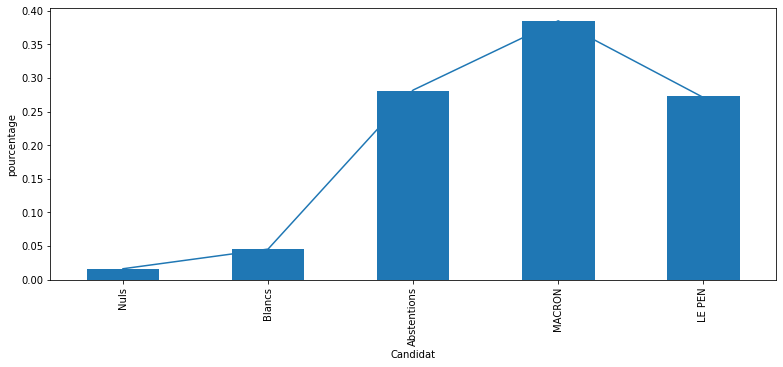

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_2' is not defined

>>>>>>> remote <modified: >


In [66]:
fig, ax = plt.subplots(figsize=(13, 5))
k = df_2.sum()/df_2.sum().sum()
ax = k.plot.bar(ax=ax)
p_2_average = (p_2*sum_2[:, None]).sum(axis=0)/sum_2.sum()
ax.plot(p_2_average)
ax.set_xlabel('Candidat')
ax.set_ylabel('pourcentage');

Ainsi que la concordance entre les résultats finaux obtenu est ce que nous représentons dans notre modèle :

In [67]:
k*100, p_2_average*100

<<<<<<< local


(Nuls            1.651714
 Blancs          4.582147
 Abstentions    28.010677
 MACRON         38.497926
 LE PEN         27.257536
 dtype: float64,
 tensor([ 1.6266,  4.5513, 28.2081, 38.5074, 27.1066]))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'k' is not defined

>>>>>>> remote <modified: >


In [68]:
F.binary_cross_entropy(p_2_average, p_2_average, reduction="sum")

<<<<<<< local


tensor(2.1139)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'F' is not defined

>>>>>>> remote <modified: >


### Modèle `torch` d'apprentissage:

Maintenant que nous avons défini le modèle de transition des probabilités entre les préférences au premier tour et au second tour, nous pouvons maintenant écrire un algorithme d'apprentissage qui permet d'optimiser la concordance entre la prédiction et les observations. 

Nous allons utiliser les distributions observées $q$ et prédites $\hat{q}$ (celle-ci dépendant de $M$) pour calculer un coût à minimiser
$$
\mathcal{L} =  KL(q, \hat{q})
$$

où la [divergence de Kullback-Leibler](https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler) est calculée comme

$$
KL(P, Q) = \sum_j P_j \cdot \log \frac {P_j}{Q_j}
$$


Cette divergence est l'équivalent d'une distance dans les espaces de probabilité. Mathémamatiquement, c'est une semi-normes car elle obéit à deux propriétés fondamentales: elle est toujours positive et est égale à zéro quand elle est appliquée à distributions identiques.

In [118]:
import torch.nn.functional as F

learning_rate = 0.05
beta1, beta2 = 0.9, 0.999
num_epochs = 2 ** 10 + 1
batch_size = 2 ** 14
do_optim = True
do_optim = False

def fit_data(
    df_1,
    df_2,
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    beta1=beta1,
    beta2=beta2, do_optim=amsgrad, 
    split_ratio=.9, 
    seed=2022, # graine du générateur de nombre aléatoires utilisé dans le split test vs train
    verbose=False
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_1er, N_2eme = len(df_1.columns), len(df_2.columns)
    trans = TransfertVoix(N_1er, N_2eme)
    trans = trans.to(device)
    X_1, X_2 = df_1.values, df_2.values
    x_1, x_2 = torch.Tensor(X_1), torch.Tensor(X_2)

    # split train and test
    dataset = TensorDataset(x_1, x_2)
    train_set_size = int(len(dataset) * split_ratio)
    test_set_size = len(dataset) - train_set_size
    train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))
    train_loader = DataLoader(train_set, batch_size=int(batch_size), shuffle=True)

    # apprentissage
    #optimizer = torch.optim.Adam(trans.parameters(), lr=learning_rate, betas=(beta1, beta2), amsgrad=do_optim)
    optimizer = torch.optim.SGD(trans.parameters(), lr=learning_rate, momentum=beta1, nesterov=do_optim)

    for epoch in range(int(num_epochs)):
        losses = []
        for n_1, n_2 in train_loader:
            n_1, n_2 = n_1.to(device), n_2.to(device)

            sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
            p_1 = n_1/sum_1[:, None]
            p_2 = n_2/sum_2[:, None]
            #p_2[p_2==0] = 1.

            p_2_pred = trans(p_1)
            weight = sum_2/sum_2.sum()
            #p_2_pred[p_2_pred==0] = 1.
            #print(p_2_pred.mean(axis=0))
            #print(p_2_pred.mean(axis=0).sum())
            if False:
                ind_nonzero = (p_2==0) + (p_2_pred==0)
                p_2[ind_nonzero] = 1.
                p_2_pred[ind_nonzero] = 1.

                #print(p_2_pred.shape, p_2_pred.min(), p_2_pred.max())
                #loss = criterion(p_2_pred, p_2, weight=sum_1/sum_1.sum())
                #print(p_2_pred.shape, p_2.shape, weight.shape)

                kl_div = p_2 * (p_2.log() - p_2_pred.log())
                loss = (kl_div * weight[:, None]).sum() # donne un poids à chaque bureau de vote proportionnel à sa taille
            else:
                loss_train = F.binary_cross_entropy(p_2_pred, p_2, reduction="sum", weight=weight[:, None])
                loss_train /= F.binary_cross_entropy(p_2, p_2, reduction="sum", weight=weight[:, None])
                loss_train -= 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} / {num_epochs} - Loss: {np.sum(losses):.5e}")

    # Test
    with torch.no_grad():
        n_1, n_2 = dataset[test_set.indices]
        sum_1, sum_2 = n_1.sum(axis=1), n_2.sum(axis=1)
        p_2 = n_2/sum_2[:, None]
        p_1 = n_1/sum_1[:, None]
        p_2_pred = trans(p_1)

        weight = sum_2/sum_2.sum()
        loss_test = F.binary_cross_entropy(p_2_pred, p_2, reduction="sum", weight=weight[:, None])
        loss_test /= F.binary_cross_entropy(p_2, p_2, reduction="sum", weight=weight[:, None])
        loss_test -= 1

    return trans, loss_train, loss_test, p_1, p_2, p_2_pred

<<<<<<< local <removed>


ModuleNotFoundError: No module named 'torch'

>>>>>>> remote <modified: >


In [119]:
trans, loss_train, loss_test, p_1, p_2, p_2_pred = fit_data(df_1, df_2, verbose=True)

<<<<<<< local


Iteration: 0 / 1025 - Loss: 4.76653e+00
Iteration: 32 / 1025 - Loss: 1.32915e+00
Iteration: 64 / 1025 - Loss: 1.14460e+00
Iteration: 96 / 1025 - Loss: 1.08771e+00
Iteration: 128 / 1025 - Loss: 1.05690e+00
Iteration: 160 / 1025 - Loss: 1.03846e+00
Iteration: 192 / 1025 - Loss: 1.02528e+00
Iteration: 224 / 1025 - Loss: 1.01402e+00
Iteration: 256 / 1025 - Loss: 1.00221e+00
Iteration: 288 / 1025 - Loss: 9.90654e-01
Iteration: 320 / 1025 - Loss: 9.79329e-01
Iteration: 352 / 1025 - Loss: 9.71471e-01
Iteration: 384 / 1025 - Loss: 9.66300e-01
Iteration: 416 / 1025 - Loss: 9.62196e-01
Iteration: 448 / 1025 - Loss: 9.59855e-01
Iteration: 480 / 1025 - Loss: 9.52292e-01
Iteration: 512 / 1025 - Loss: 9.44418e-01
Iteration: 544 / 1025 - Loss: 9.27968e-01
Iteration: 576 / 1025 - Loss: 8.58566e-01
Iteration: 608 / 1025 - Loss: 6.71190e-01
Iteration: 640 / 1025 - Loss: 6.18093e-01
Iteration: 672 / 1025 - Loss: 6.05870e-01
Iteration: 704 / 1025 - Loss: 6.00519e-01
Iteration: 736 / 1025 - Loss: 5.97735e-

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'fit_data' is not defined

>>>>>>> remote <modified: >


<<<<<<< local


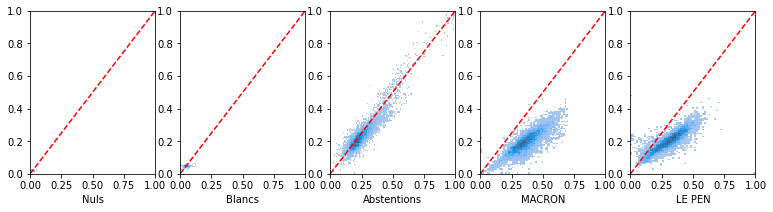

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'N_2eme' is not defined

>>>>>>> remote <modified: >


In [120]:
fig, axs = plt.subplots(1, N_2eme, figsize=(13, 3))
for i_col, candidat in enumerate(df_2.columns):
    #axs[i_col].scatter(p_2[:,i_col], p_2_pred[:,i_col], alpha=.005)
    axs[i_col].plot([0, 1], [0, 1], 'r--')
    sns.histplot(x=p_2[:, i_col], y=p_2_pred[:, i_col], ax=axs[i_col])
    axs[i_col].set_xlabel(candidat)
    axs[i_col].set_xlim(0, 1)
    axs[i_col].set_ylim(0, 1)

Ces graphiques représentent en abscisse les probabilités observées et en ordonnée les probabilités prédites. L'intérieur du graphique représente au niveau de bleu l'histogramme des différentes valeurs telles qu'elles sont observés sur la base de test, c'est-à-dire sur 10 % de l'ensemble des bureeaux de vote.

On peut maintenant récupérer du modèle la matrice de transition qui a été inférée grâce a notre apprentissage automatique :

In [121]:
M = torch.softmax(trans.M, axis=0).detach().numpy()
M

<<<<<<< local


array([[0.2, 0.2, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0.2],
       [0.2, 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 1. , 0. ],
       [0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8],
       [0.1, 0.2, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0.4, 0.1, 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. ],
       [0.1, 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ]], dtype=float32)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'torch' is not defined

>>>>>>> remote <modified: >


On vérifie dans un premier temps que la contrainte est toujours bien respectée :

In [122]:
M.sum(axis=0), M.shape

<<<<<<< local


(array([1., 1., 1., 1., 1.], dtype=float32), (15, 5))

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'M' is not defined

>>>>>>> remote <modified: >


Nous allons nous inspirer d'[un graphique de la galerie matplotlib](https://matplotlib.org/stable/gallery/misc/table_demo.html#sphx-glr-gallery-misc-table-demo-py) pour représenter la la proportion des report de voir en fonction de chacun des choix FE au deuxième tour :

<<<<<<< local


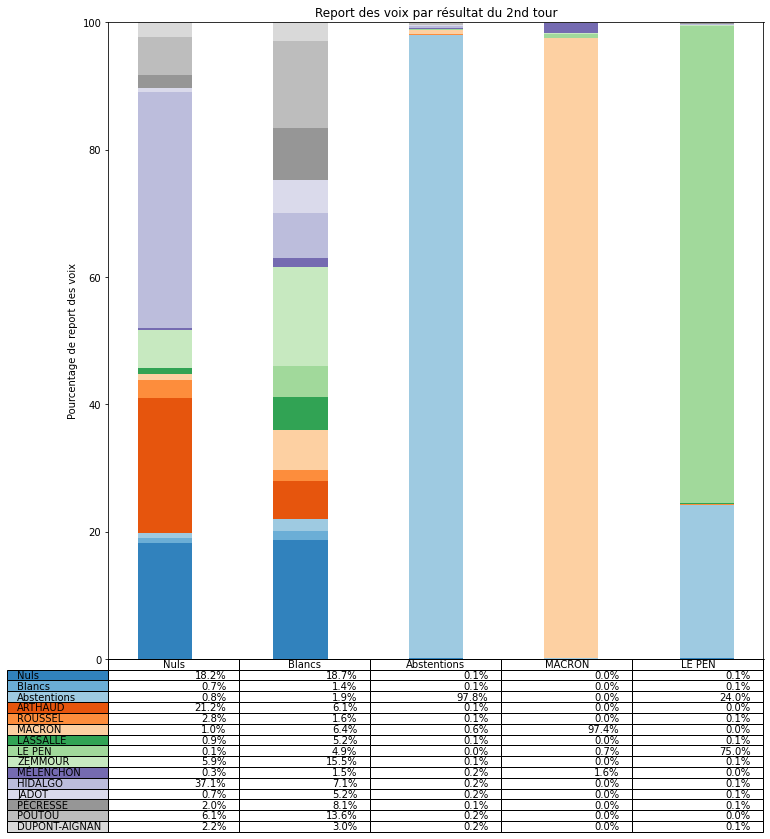

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_2' is not defined

>>>>>>> remote <modified: >


In [123]:
fig, ax = plt.subplots(figsize=(13, 13))

columns = df_2.columns
rows = df_1.columns

# Get some shades for the colors
colors = plt.cm.tab20c(np.linspace(0, 1, len(rows)))
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(index, M[row]*100, bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + M[row]*100
    cell_text.append([f'{x*100:1.1f}%' for x in M[row]])
ax.set_ylim(0, 100)

# Add a table at the bottom of the axes
the_table = ax.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Pourcentage de report des voix")
plt.yticks(np.linspace(0, 100, 6, endpoint=True))
plt.xticks([])
plt.title("Report des voix par résultat du 2nd tour");

C'est des données. Ces données correspondent aux intuitions qu'on peut se faire quand au report des votes. Notamment on remarque que la plupart des individus qui s'abstiennent au second tour se sont abstenus au premier (avec une petite proportion de Mélenchon qui se sont abstenus). Remarque aussi que la majorité des électeurs de Le Pen au premier tour en voter pour la même personne au deuxième tour. Environ un quart des électeurs de Le Pen au second tour s'était abstenu au premier.

In [124]:
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
M*100

<<<<<<< local


array([[18.2, 18.7,  0.1,  0. ,  0.1],
       [ 0.7,  1.4,  0.1,  0. ,  0.1],
       [ 0.8,  1.9, 97.8,  0. , 24. ],
       [21.2,  6.1,  0.1,  0. ,  0. ],
       [ 2.8,  1.6,  0.1,  0. ,  0.1],
       [ 1. ,  6.4,  0.6, 97.4,  0. ],
       [ 0.9,  5.2,  0.1,  0. ,  0.1],
       [ 0.1,  4.9,  0. ,  0.7, 75. ],
       [ 5.9, 15.5,  0.1,  0. ,  0.1],
       [ 0.3,  1.5,  0.2,  1.6,  0. ],
       [37.1,  7.1,  0.2,  0. ,  0.1],
       [ 0.7,  5.2,  0.2,  0. ,  0.1],
       [ 2. ,  8.1,  0.1,  0. ,  0.1],
       [ 6.1, 13.6,  0.2,  0. ,  0. ],
       [ 2.2,  3. ,  0.2,  0. ,  0.1]], dtype=float32)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'M' is not defined

>>>>>>> remote <modified: >


On observe aussi quelques points intéressants dans les votes nuls qui proviennent majoritairement de voteur "nul" au premier tour (40 %) et ensuite par des électeurs ayant voté pour des candidats marginaux au premier tour (Arnaud, Lassalle, Hidalgo). On observe à peu près la même structure pour les voteurs "blanc" avec cette particularité que les individus ayant voté pour Jadot au premier tour ont relativement plus exprimé de votes "blanc" (~12 %) par rapport à ce qu'on observe pour les votes "nul". On rappelle qu'en France, un vote nul est un bulletin qui n'a pas été validé car il est par exemple raturé alors qu'un vote blanc est exprimé par un bulletin de vote totalement blanc (et qu'il faut préparer en avance). On peut donc expliquer ce dernier par rapport aux particularités du vote écologiques liés aux candidat Jadot.

Muni de cette matrice de transition on peut maintenant opérer une transformation de telle sorte à ce que nous allons regarder la distribution des report de voix pour chacun des choix qui sont faits au premier tour.

In [125]:
MT = M.T
MT /= MT.sum(axis=0)
MT*100

<<<<<<< local


array([[49.1, 31.6,  0.6, 77.4, 60.6,  0.9, 14.8,  0.1, 27.3,  8. , 83.4,
        11. , 19.1, 30.5, 40.7],
       [50.3, 60.4,  1.5, 22.1, 35.1,  6. , 82.2,  6.1, 71.7, 42. , 15.9,
        83.2, 79.1, 68.4, 54.1],
       [ 0.2,  4.7, 78.5,  0.3,  2. ,  0.6,  1.2,  0.1,  0.5,  4.6,  0.4,
         3.6,  0.8,  0.9,  2.9],
       [ 0.1,  1. ,  0. ,  0.1,  0.4, 92.4,  0.3,  0.8,  0. , 44.3,  0. ,
         0.5,  0.3,  0.1,  0.4],
       [ 0.2,  2.3, 19.3,  0.1,  1.9,  0. ,  1.4, 92.9,  0.4,  1.1,  0.3,
         1.6,  0.8,  0.1,  1.9]], dtype=float32)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'M' is not defined

>>>>>>> remote <modified: >


<<<<<<< local


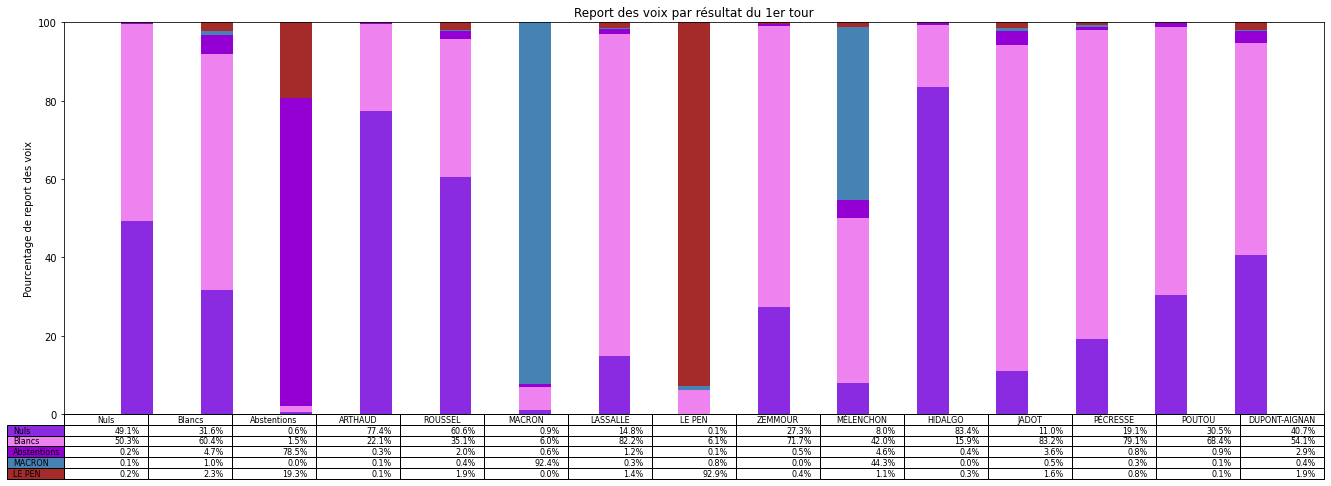

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


In [126]:
fig, ax = plt.subplots(figsize=(25, 8))

columns = df_1.columns
rows = df_2.columns

# named colors: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ['blueviolet', 'violet', 'darkviolet', 'steelblue', 'brown' ]
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(index, MT[row]*100, bar_width, bottom=y_offset, color=colors[row], linewidth=1)
    y_offset = y_offset + MT[row]*100
    cell_text.append([f'{x*100:1.1f}%' for x in MT[row]])
ax.set_ylim(0, 100)

# Add a table at the bottom of the axes
the_table = ax.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Pourcentage de report des voix")
plt.yticks(np.linspace(0, 100, 6, endpoint=True))
plt.xticks([])
plt.title("Report des voix par résultat du 1er tour");

On peut aussi se restreindre aux votes exprimés :

In [127]:
MT = M[3:, 3:].T
MT /= MT.sum(axis=0)
MT*100

<<<<<<< local


array([[48.6, 18.5, 99.9, 19.6,  0.9, 10.2, 97.5,  9.8, 25.3, 29.5, 39.5,
        18.6],
       [51.4, 81.5,  0.1, 80.4, 99.1, 89.8,  2.5, 90.2, 74.7, 70.5, 60.5,
        81.4]], dtype=float32)

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'M' is not defined

>>>>>>> remote <modified: >


<<<<<<< local


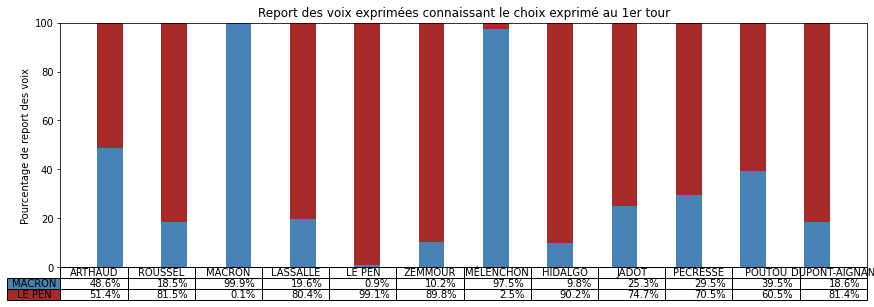

>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'df_1' is not defined

>>>>>>> remote <modified: >


In [128]:
fig, ax = plt.subplots(figsize=(16, 5))

columns = df_1.columns[3:]
rows = df_2.columns[3:]

# named colors: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ['steelblue', 'brown' ]
n_rows = len(rows)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(index, MT[row]*100, bar_width, bottom=y_offset, color=colors[row], linewidth=1)
    y_offset = y_offset + MT[row]*100
    cell_text.append([f'{x*100:1.1f}%' for x in MT[row]])
ax.set_ylim(0, 100)
# Add a table at the bottom of the axes
the_table = ax.table(cellText=cell_text, colLoc='center', 
                      rowLabels=rows, rowLoc='center',
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Pourcentage de report des voix")
plt.yticks(np.linspace(0, 100, 6, endpoint=True))
plt.xticks([])
plt.title("Report des voix exprimées connaissant le choix exprimé au 1er tour")
plt.savefig('2022-05-04_transfert-des-voix.png');

Ce tableau donne le pourcentage de chances d'exprimer une voix pour un candidat ou pour l'autre en fonction du choix qu'on a exprimé au premier tour. 

Ce tableau montre des tendances claires, par exemple que si on a voté Macron, Jadot ou Pécresse au premier tour, alors on va certainement voter Macron au deuxième tour. Ses électeurs se montre particulièrement consensuel et suivent le « pacte républicain » mise en place pour faire un barrage au Front National. Il montre aussi que si on a voté Le Pen ou Dupont-Aignan au premier tour alors on va voter Le Pen au deuxième, un clair vote de suivi. (On pourra aussi remarquer les ~ 3 % des voix pour Macron au premier tour qui ont voté Le Pen au deuxième tour, soit tout de même environ 320k individus…)

Connaissant les couleurs politiques d'autres candidats du premier tour, on peut être surpris que les électeurs de Arthaud, Roussel ou Hidalgo ont majoritairement choisi Le Pen au deuxième tour, signifiant alors un rejet du candidat Macron. Les électeurs de Zemmour sont aussi partagés, signifiant un rejet des deux alternatives. **Ce résultat est à prendre avec des pincettes car ces derniers candidats ont obtenu moins de votes et donc que le processus d'inférence est forcément moins précis car il y a moins de données disponibles.** Pour se rendre compte de la variabilité des résultats qu'on obtient là, je conseille au lecteur (*à l'électeur*) de relancer ces notebook en utilisant différents « graines » pour le générateur de nombre aléatoire qui permet de séparer les données (le paramètre `seed`).

In [129]:
print(f"""
Total des voix au 1er tour= {x_1.sum():.0f}, dont Macron = {x_1[:, 5].sum():.0f} (soit une pourcentage de {x_1[:, 5].sum()/x_1.sum()*100:.2f}%), 
-> nombre de reports de Macron du 1er vers Le Pen au 2eme = {x_1[:, 5].sum()*MT[1, 2]:.0f} personnes.
""")

<<<<<<< local



Total des voix au 1er tour= 48747864, dont Macron = 9783058 (soit une pourcentage de 20.07%), 
-> nombre de reports de Macron du 1er vers Le Pen au 2eme = 4912 personnes.



>>>>>>> remote


<<<<<<< local <removed>


NameError: name 'x_1' is not defined

>>>>>>> remote <modified: >


### influence des parametres

Finalement, on valide nos résultats en testant différentes paramétrisation de l'apprentissage et en donnant la valeur du loss calculé sur la base de test :

In [ ]:
trans, loss_train_alt, loss_test_alt, p_1, p_2, p_2_pred = fit_data(df_1, df_2, learning_rate=learning_rate_, verbose=False, do_optim=not do_optim)
print('Loss avec {do_optim=} = {loss_test:.2f} / Loss avec do_optim={not do_optim} = {loss_test_alt:.2f} ')
print('Loss avec {do_optim=} = {loss_train:.2f} / Loss avec do_optim={not do_optim} = {loss_train_alt:.2f} ')

In [ ]:
N_scan = 7
results_train, results_test = [], []

learning_rates = learning_rate * np.logspace(-1, 1, 7, base=10)
for learning_rate_ in learning_rates:
    trans, loss_train, loss_test, p_1, p_2, p_2_pred = fit_data(df_1, df_2, learning_rate=learning_rate_, verbose=False)
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(learning_rates, results_train, '--')
ax.plot(learning_rates, results_test)
ax.set_xlabel = 'learning rate'
ax.set_ylabel = 'Loss'
ax.set_xscale = 'log'

In [81]:
trans, loss_alt, p_1, p_2, p_2_pred = fit_data(df_1, df_2, learning_rate=learning_rate_, verbose=False, amsgrad=not amsgrad)
print('Loss avec {amsgrad=} = {loss:.2f} / Loss avec amsgrad={not amsgrad} = {loss_alt:.2f} ')

NameError: name 'fit_data' is not defined

In [82]:
N_scan = 7
results = []

learning_rates = learning_rate * np.logspace(-1, 1, 7, base=10)
for learning_rate_ in learning_rates:
    trans, loss, p_1, p_2, p_2_pred = fit_data(df_1, df_2, learning_rate=learning_rate_, verbose=False)
    results.append(loss)

NameError: name 'learning_rate' is not defined

NameError: name 'learning_rates' is not defined

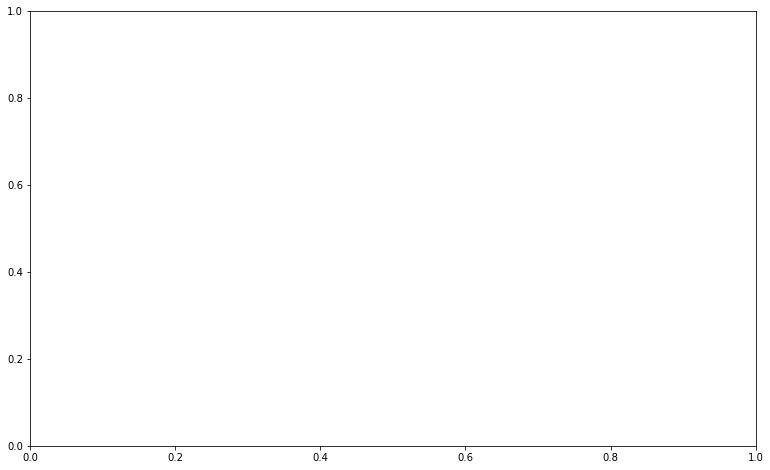

In [83]:
fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(learning_rates, results)
ax.set_xlabel = 'learning rate'
ax.set_ylabel = 'Loss'
ax.set_xscale = 'log'

In [ ]:
import time
results_train, results_test = [], []
batch_sizes = (batch_size * np.arange(1, N_scan) ** 2) // 8
print(batch_sizes)
for batch_size_ in batch_sizes:
    tic = time.time()
    trans, loss_train, loss_test, p_1, p_2, p_2_pred = fit_data(df_1, df_2, batch_size=batch_size_, verbose=False)
    print(f'Pour batch_size= {batch_size_}, le temps de calcul est {time.time()-tic:.3f} s')
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(batch_sizes, results_train, '--')
ax.plot(batch_sizes, results_test)
ax.set_xlabel = 'batch size'
ax.set_ylabel = 'Loss'

<<<<<<< local <removed>


NameError: name 'batch_size' is not defined

>>>>>>> remote <modified: >


NameError: name 'batch_sizes' is not defined

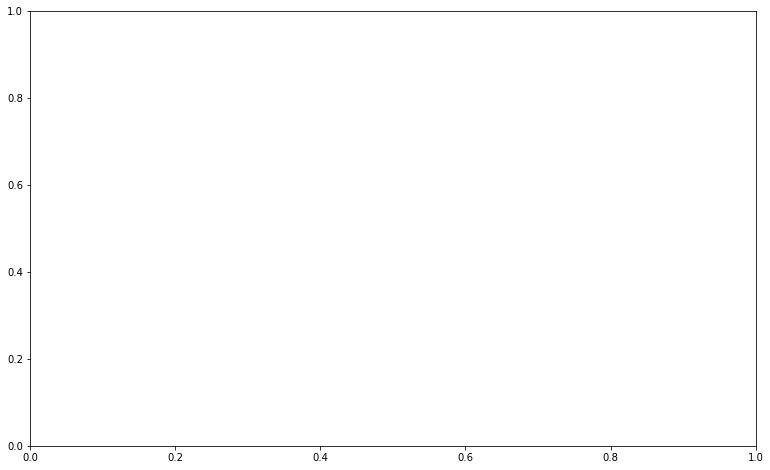

In [85]:
fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(batch_sizes, results)
ax.set_xlabel = 'batch size'
ax.set_ylabel = 'Loss'

In [ ]:
results_train, results_test = [], []
beta1s = 1 - (1 - beta1) * np.logspace(-1, 1, 7, base=10)
for beta1_ in beta1s:
    trans, loss_train, loss_test, p_1, p_2, p_2_pred = fit_data(df_1, df_2, beta1=beta1_, verbose=False)
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(beta1s, results_train, '--')
ax.plot(beta1s, results_test)
ax.set_xlabel = 'beta1'
ax.set_ylabel = 'Loss'

<<<<<<< local <removed>


NameError: name 'beta1' is not defined

>>>>>>> remote <modified: >


In [ ]:
results_train, results_test = [], []
beta2s = 1 - (1 - beta2) * np.logspace(-1, 1, 7, base=10)
for beta2_ in beta2s:
    trans, loss_train, loss_test, p_1, p_2, p_2_pred = fit_data(df_1, df_2, beta2=beta2_, verbose=False)
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(beta2s, results_train, '--')
ax.plot(beta2s, results_test)
ax.set_xlabel = 'beta2'
ax.set_ylabel = 'Loss'

<<<<<<< local <removed>


NameError: name 'beta2' is not defined

>>>>>>> remote <modified: >


In [ ]:
results_train, results_test = [], []
num_epochss = (num_epochs * np.arange(1, N_scan) ** 2) // 8
print(num_epochss)
for num_epochs_ in num_epochss:
    tic = time.time()
    trans, loss_train, loss_test, p_1, p_2, p_2_pred = fit_data(df_1, df_2, num_epochs=num_epochs_, verbose=False)
    print(f'Pour num_epochs={num_epochs_}, le temps de calcul est {time.time()-tic:.3f} s')
    results_train.append(loss_train)
    results_test.append(loss_test)

fig, ax = plt.subplots(figsize = (13, 8))
ax.plot(num_epochss, results_train, '--')
ax.plot(num_epochss, results_test)
ax.set_xlabel = 'batch size'
ax.set_ylabel = 'Loss'

<<<<<<< local <removed>


NameError: name 'num_epochs' is not defined

>>>>>>> remote <modified: >
